# Importing Modules and loading data

In [15]:
import sys
import os
sys.path.append('./Scripts')
sys.path.append('./Files')
sys.path.append('./Datasets')

In [2]:
os.system('pip install nltk')
os.system('pip install openpyxl')
os.system('pip install emot')

0

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import openpyxl
import emot
import pickle

# from google.colab import files
from nltk.corpus import stopwords
import nltk
import seaborn as sns
nltk.download('punkt')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from Sequencer import Sequencer
from helper_fns import write_dict
from helper_fns import read_dict

from dataCleaner import clean_arabic_text

import ArStemmerLib as lib
import lexicon
from lexicon import calc_lexicon

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\youss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
data_path = "Text Preprocessing Experimentations/exp1_train_rtp_rl_re_cat_rl_qalsadi.csv"

In [18]:
df = pd.read_csv(data_path)
df.dropna(inplace=True)

In [8]:
# tweets_df = pd.read_csv('Datasets/tweets_sns2.csv')
# keep_regex = "[Vv]odafone|VODAFONE|فودافون|[Ee]tisalat|ETISALAT|اتصالات|[Oo]range|ORANGE|اورانج|موبينيل|إتصالات|أورانج"
# remove_regex = "لون"
# drop_indeces = tweets_df[(tweets_df['text'].str.contains(keep_regex)==False) | (tweets_df['text'].str.contains(remove_regex)==True)].index
# tweets_df.drop(drop_indeces, inplace=True)
# tweets= tweets_df['text'].copy()
# tweets2 = df['tweet'].copy()
# tokens1 = set(nltk.word_tokenize(' '.join(tweets.to_numpy().flatten())))
# tokens2 = set(nltk.word_tokenize(' '.join(tweets2.to_numpy().flatten())))
# def tweet_filter(tweet: str, bucket: set[str]) -> bool:
#     tokens = set(nltk.word_tokenize(tweet))
#     inclusion_ratio =  len(tokens.intersection(bucket)) / len(tokens)
#     return inclusion_ratio >= 0.5

# filtered_tweets = tweets.to_numpy()[[tweet_filter(x, tokens2) for x in tweets.to_numpy()]]

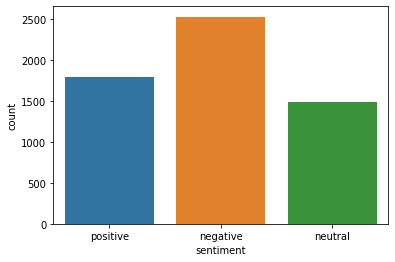

In [19]:
_ = sns.countplot(x='sentiment', data=df)

# Preparing Vectorized data 

## Count Vectorizer

In [20]:
count_vec = CountVectorizer(ngram_range=(1,1))

In [21]:
count_data = count_vec.fit_transform(df['tweet'])

## TF-IDF

In [22]:
tfidf_vec = TfidfVectorizer()

In [23]:
tfidf_data = tfidf_vec.fit_transform(df['tweet'])

## Word2Vec

In [30]:
def embed_data(df, embeddings_dict, embedding_padding):

    sequencer = Sequencer(df['tweet'], embeddings_dict, embedding_padding)

    embeddings_matrix = []
    for tweet in df['tweet']:
        tweet_vec = sequencer.padder(sequencer.text_to_vec(tweet))
        embeddings_matrix.append(tweet_vec)
    embeddings_matrix = np.array(embeddings_matrix)

    embedded_data = pd.DataFrame(embeddings_matrix)

    for i in range(embedding_padding):
        embedded_data[i] =(embedded_data[i] - embedded_data[i].mean() ) / embedded_data[i].std()
    
    return embedded_data

### Skip-Gram

In [31]:
skipgram_path = "Word Embeddings/sg_dict_exp1_5_2_100.txt"

In [32]:
skipgram_dict = read_dict(skipgram_path)

In [33]:
sg_padding = 1000

In [34]:
skipgram_data = embed_data(df, skipgram_dict, sg_padding)

In [35]:
skipgram_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.271038,-1.527171,1.474904,0.631825,-0.723927,1.081868,-0.939506,-1.151725,1.179911,0.807985,...,0.340937,0.394804,0.340109,-0.425280,0.341927,0.288703,0.168849,-0.262509,0.545395,-0.910550
1,-0.041479,0.789409,0.428717,0.480546,-0.184204,-0.129974,-0.132827,0.367455,0.065133,-0.617037,...,-0.946921,-0.947947,-0.946971,0.795187,-0.947575,-0.946875,-0.930535,0.949500,-0.940034,0.788748
2,-1.130396,-0.650507,-0.487321,-1.149445,1.986815,-0.590338,0.106037,0.654020,-0.914656,-0.779677,...,0.371212,0.256357,0.431265,-0.353342,0.241366,0.369325,0.245575,-0.260409,0.475285,0.259021
3,-0.349906,0.751071,0.408079,-0.914289,0.639183,-0.211042,0.386194,0.292230,-0.440142,0.066203,...,-0.946921,-0.947947,-0.946971,0.795187,-0.947575,-0.946875,-0.930535,0.949500,-0.940034,0.788748
4,-0.095861,0.839597,0.557592,-0.331591,0.954286,-0.622397,0.431203,0.561547,-0.489602,0.306158,...,-0.946921,-0.947947,-0.946971,0.795187,-0.947575,-0.946875,-0.930535,0.949500,-0.940034,0.788748


### CBOW

In [41]:
cbow_path = "Word Embeddings/cb_dict_exp1_5_2_100.txt"

In [42]:
cbow_dict = read_dict(cbow_path)

In [43]:
cb_padding = 1000

In [44]:
cbow_data = embed_data(df, cbow_dict, cb_padding)

In [45]:
cbow_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.466028,-1.542237,1.587045,1.498302,-1.385265,1.404378,-1.382232,-1.415088,1.426477,1.365116,...,-0.393273,-0.369322,-0.404756,0.303971,-0.399949,-0.431631,-0.437717,0.453755,-0.314152,-1.952366
1,0.638552,-0.493738,0.676737,0.910908,-0.650437,0.624788,-0.694716,-0.560525,0.659683,0.508297,...,-0.761202,-0.761376,-0.760584,0.690160,-0.760800,-0.762038,-0.761485,0.761840,-0.763015,-0.367676
2,-1.208991,0.998348,-1.229029,-1.476950,1.347140,-1.156843,1.063357,1.150610,-1.250804,-1.139106,...,-0.462794,-0.525928,-0.426347,0.440855,-0.528031,-0.459367,-0.507294,0.535991,-0.433973,0.701467
3,-0.207738,0.251813,-0.099799,-0.617206,0.270799,-0.176866,0.223796,0.201109,-0.234088,-0.172313,...,-0.761202,-0.761376,-0.760584,0.690160,-0.760800,-0.762038,-0.761485,0.761840,-0.763015,-0.367676
4,0.343595,-0.214957,0.398737,0.136776,-0.151041,0.243066,-0.255637,-0.249155,0.253996,0.381233,...,-0.761202,-0.761376,-0.760584,0.690160,-0.760800,-0.762038,-0.761485,0.761840,-0.763015,-0.367676


# Splitting data

In [46]:
X_train_tfidf,X_test_tfidf,Y_train_tfidf,Y_test_tfidf = train_test_split(tfidf_data, df['sentiment'], test_size=0.25, random_state=1)

In [47]:
X_train_count,X_test_count,Y_train_count,Y_test_count = train_test_split(count_data, df['sentiment'], test_size=0.25, random_state=1)

In [48]:
X_train_sg ,X_test_sg ,Y_train_sg ,Y_test_sg  = train_test_split(skipgram_data, df['sentiment'], test_size=0.25, random_state=1)

In [49]:
X_train_cb ,X_test_cb ,Y_train_cb ,Y_test_cb  = train_test_split(cbow_data, df['sentiment'], test_size=0.25, random_state=1)

In [50]:
X_train ,X_test ,Y_train ,Y_test  = train_test_split(df['tweet'], df['sentiment'], test_size=0.25, random_state=1)

In [51]:
Y_test_tfidf.head()

6333    positive
4891    positive
1050     neutral
5629     neutral
6434     neutral
Name: sentiment, dtype: object

In [15]:
# le = LabelEncoder()
# Y_test_tfidf = le.fit_transform(Y_test_tfidf)
# Y_test_count = le.fit_transform(Y_test_count)
# Y_test = le.fit_transform(Y_test)
# Y_train_tfidf = le.fit_transform(Y_train_tfidf)
# Y_train_count = le.fit_transform(Y_train_count)
# Y_train = le.fit_transform(Y_train)

# Modelling

## Naive Bayes

In [52]:
cl = MultinomialNB()

### Lexicon + Count Vectorizer

In [53]:
#calculate the lexicon
tweet_train_lex = []
for tweet in X_train:
    tweet_train_lex.append(calc_lexicon(u"%s" %tweet))

tweet_test_lex = []
for tweet in X_test:
    tweet_test_lex.append(calc_lexicon(u"%s" %tweet))

In [54]:
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
tweet_lex_train_sparse = csr_matrix(tweet_train_lex)
tweet_lex_test_sparse = csr_matrix(tweet_test_lex)
tweet_lex_test_sparse

<1454x2 sparse matrix of type '<class 'numpy.float64'>'
	with 1237 stored elements in Compressed Sparse Row format>

In [55]:
train_feature_matrix = hstack((X_train_count, tweet_lex_train_sparse))
test_feature_matrix = hstack((X_test_count, tweet_lex_test_sparse))
test_feature_matrix

<1454x14030 sparse matrix of type '<class 'numpy.float64'>'
	with 18586 stored elements in Compressed Sparse Row format>

In [56]:
nb_lexicon = cl.fit(train_feature_matrix,Y_train)
predicted = cl.predict(test_feature_matrix)
acc = accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,predicted))

accuracy = 61.27922971114168%
              precision    recall  f1-score   support

    negative       0.66      0.77      0.71       682
     neutral       0.36      0.19      0.25       362
    positive       0.64      0.73      0.68       410

    accuracy                           0.61      1454
   macro avg       0.55      0.56      0.55      1454
weighted avg       0.58      0.61      0.59      1454



In [57]:
nb_lex_model_path = 'Models/nb_lexicon_model.sav'
pickle.dump(nb_lexicon, open(nb_lex_model_path,'wb'))

### TF-IDF

In [58]:
nb_tfidf = cl.fit(X_train_tfidf, Y_train_tfidf)
p = cl.predict(X_test_tfidf)
acc = accuracy_score(Y_test_tfidf,p)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,p))

accuracy = 61.141678129298484%
              precision    recall  f1-score   support

    negative       0.57      0.95      0.72       682
     neutral       0.58      0.03      0.06       362
    positive       0.75      0.56      0.64       410

    accuracy                           0.61      1454
   macro avg       0.63      0.51      0.47      1454
weighted avg       0.62      0.61      0.53      1454



In [59]:
nb_tfidf_model_path = 'Models/nb_tfidf_model.sav'
pickle.dump(nb_tfidf, open(nb_tfidf_model_path,'wb'))

### Lexicon + TF-IDF

In [60]:
train_feature_matrix_tf = hstack((X_train_tfidf, tweet_lex_train_sparse))
test_feature_matrix_tf = hstack((X_test_tfidf, tweet_lex_test_sparse))
test_feature_matrix_tf

<1454x14030 sparse matrix of type '<class 'numpy.float64'>'
	with 18586 stored elements in Compressed Sparse Row format>

In [61]:
nb_lex_tfidf = cl.fit(train_feature_matrix_tf,Y_train)
predicted = cl.predict(test_feature_matrix_tf)
acc = accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,predicted))

accuracy = 62.17331499312242%
              precision    recall  f1-score   support

    negative       0.61      0.90      0.73       682
     neutral       0.52      0.03      0.06       362
    positive       0.65      0.68      0.66       410

    accuracy                           0.62      1454
   macro avg       0.59      0.54      0.48      1454
weighted avg       0.60      0.62      0.54      1454



In [62]:
nb_lex_tfidf_model_path = 'Models/nb_lex_tfidf_model.sav'
pickle.dump(nb_lex_tfidf, open(nb_lex_tfidf_model_path,'wb'))

## Logistic Regression

### TF-IDF

In [63]:
lg =  LogisticRegression(max_iter=1000)

In [64]:
# make param grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# create and fit the model
model = GridSearchCV(lg, param_grid, cv=10)

In [65]:
lg_model_path = 'Models/exp1_lg_tfidf_model.sav'

In [66]:
model.fit(X_train_tfidf,Y_train_tfidf)
pickle.dump(model, open(lg_model_path,'wb'))

In [71]:
# make prediction and print accuracy
prediction = model.predict(X_test_tfidf)
print ('accuracy = '+str(accuracy_score(Y_test_tfidf, prediction)*100)+'%')

accuracy = 62.379642365887214%


In [70]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

    negative       0.61      0.87      0.72       682
     neutral       0.42      0.14      0.21       362
    positive       0.72      0.64      0.68       410

    accuracy                           0.62      1454
   macro avg       0.59      0.55      0.54      1454
weighted avg       0.60      0.62      0.58      1454



### Lexicon + Count Vectorizer

In [72]:
lg_lexicon = model.fit(train_feature_matrix,Y_train)
pickle.dump(model, open(lg_model_path,'wb'))
prediction = model.predict(test_feature_matrix)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.61
              precision    recall  f1-score   support

    negative       0.65      0.77      0.71       682
     neutral       0.43      0.20      0.27       362
    positive       0.62      0.72      0.67       410

    accuracy                           0.61      1454
   macro avg       0.57      0.56      0.55      1454
weighted avg       0.59      0.61      0.59      1454



In [77]:
lg_lexicon_model_path = 'Models/lg_lexicon_model.sav'
pickle.dump(lg_lexicon, open(lg_lexicon_model_path,'wb'))

## Complement Naive Bayes

### TF-IDF

In [78]:
CNB = ComplementNB()

In [75]:
CNB.fit(X_train_tfidf, Y_train_tfidf)

ComplementNB()

In [76]:
predicted = CNB.predict(X_test_tfidf)
acc = accuracy_score(Y_test_tfidf,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_tfidf,predicted))

accuracy = 60.66024759284731%
              precision    recall  f1-score   support

    negative       0.65      0.73      0.69       682
     neutral       0.36      0.21      0.26       362
    positive       0.64      0.75      0.69       410

    accuracy                           0.61      1454
   macro avg       0.55      0.56      0.55      1454
weighted avg       0.58      0.61      0.58      1454



## SVC

In [79]:
SVM_SVC = SVC()

### Skip-Gram Embedding

In [80]:
svc_embedding = SVM_SVC.fit(X_train_sg,Y_train_sg)
predicted = svc_embedding.predict(X_test_sg)
acc = accuracy_score(Y_test_sg,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_sg,predicted))

accuracy = 51.788170563961486%
              precision    recall  f1-score   support

    negative       0.52      0.84      0.64       682
     neutral       0.00      0.00      0.00       362
    positive       0.52      0.44      0.48       410

    accuracy                           0.52      1454
   macro avg       0.35      0.43      0.37      1454
weighted avg       0.39      0.52      0.44      1454



### CBOW Embedding

In [81]:
svc_embedding = SVM_SVC.fit(X_train_cb,Y_train_cb)
predicted = svc_embedding.predict(X_test_cb)
acc = accuracy_score(Y_test_cb,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_cb,predicted))

accuracy = 47.86795048143054%
              precision    recall  f1-score   support

    negative       0.50      0.80      0.62       682
     neutral       0.00      0.00      0.00       362
    positive       0.42      0.36      0.39       410

    accuracy                           0.48      1454
   macro avg       0.31      0.39      0.33      1454
weighted avg       0.35      0.48      0.40      1454



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TFIDF

In [82]:
svc_tfidf = SVM_SVC.fit(X_train_tfidf,Y_train_tfidf)
predicted = svc_tfidf.predict(X_test_tfidf)
acc = accuracy_score(Y_test_tfidf,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_tfidf,predicted))

accuracy = 62.24209078404401%
              precision    recall  f1-score   support

    negative       0.58      0.97      0.72       682
     neutral       0.71      0.04      0.08       362
    positive       0.79      0.56      0.66       410

    accuracy                           0.62      1454
   macro avg       0.69      0.52      0.49      1454
weighted avg       0.67      0.62      0.54      1454



### Count Vectorizer

In [83]:
svc_count = SVM_SVC.fit(X_train_count,Y_train_count)
predicted = svc_count.predict(X_test_count)
acc = accuracy_score(Y_test_count,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_count,predicted))

accuracy = 60.86657496561211%
              precision    recall  f1-score   support

    negative       0.57      0.94      0.71       682
     neutral       0.73      0.05      0.10       362
    positive       0.72      0.55      0.63       410

    accuracy                           0.61      1454
   macro avg       0.68      0.51      0.48      1454
weighted avg       0.65      0.61      0.53      1454



## Deep Neural Network

In [1]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(in_dim, out_dim),
    tf.keras.layers.Dense(out_dim, )
])